## short prompting score generation

**Goal**: Gap Closed (%) score for short with prompting 

**Authors**: Owen Terry, Varun Ramamurthi, Sungjoon Park  
**Last edited: 12.10.2025**

In [1]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [15]:

# ============================================================================
# STEP 1: Load all your data
# ============================================================================

def load_training_data(filepath="short_complete.jsonl"):
    """Load training data - use ALL examples."""
    print("Loading training data...")
    training_data = []
    with open(filepath, 'r') as f:
        for line in f:
            training_data.append(json.loads(line))
    
    word_counts = [len(ex['chosen'].split()) for ex in training_data]
    
    print(f"✅ Loaded {len(training_data)} training examples")
    print(f"   Training mean: {np.mean(word_counts):.2f} words\n")
    
    return {
        'mean': np.mean(word_counts),
        'median': np.median(word_counts),
        'std': np.std(word_counts),
        'count': len(word_counts),
        'word_counts': word_counts
    }

def load_test_responses(baseline_file, neo_file):
    """Load pre-generated test responses."""
    print("Loading test responses...")
    
    # Load baseline responses
    with open(baseline_file, 'r', encoding='utf-8') as f:
        baseline_data = [json.loads(line) for line in f]
    baseline_responses = [ex['response'] for ex in baseline_data]  # Adjust key as needed
    baseline_word_counts = [len(r.split()) for r in baseline_responses]
    
    # Load prompting responses
    with open(neo_file, 'r', encoding='utf-8') as f:
        neo_data = [json.loads(line) for line in f]
    neo_responses = [ex['response'] for ex in neo_data]  # Adjust key as needed
    neo_word_counts = [len(r.split()) for r in neo_responses]
    
    print(f"✅ Loaded {len(baseline_responses)} baseline responses")
    print(f"   Baseline mean: {np.mean(baseline_word_counts):.2f} words")
    print(f"✅ Loaded {len(neo_responses)} prompting responses")
    print(f"   Prompting mean: {np.mean(neo_word_counts):.2f} words\n")
    

    baseline_stats = {
        'mean': np.mean(baseline_word_counts),
        'median': np.median(baseline_word_counts),
        'std': np.std(baseline_word_counts),
        'count': len(baseline_word_counts),
        'word_counts': baseline_word_counts,
        'under_50_pct': np.mean([wc < 50 for wc in baseline_word_counts]) * 100,
        'under_75_pct': np.mean([wc < 75 for wc in baseline_word_counts]) * 100
    }
    
    neo_stats = {
        'mean': np.mean(neo_word_counts),
        'median': np.median(neo_word_counts),
        'std': np.std(neo_word_counts),
        'count': len(neo_word_counts),
        'word_counts': neo_word_counts,
        'under_50_pct': np.mean([wc < 50 for wc in neo_word_counts]) * 100,
        'under_75_pct': np.mean([wc < 75 for wc in neo_word_counts]) * 100
    }
    
    return baseline_stats, neo_stats


In [16]:

# ============================================================================
# STEP 2: Calculate Gap Closure
# ============================================================================

def calculate_gap_closure(baseline_stats, training_stats, neo_stats):
    """Calculate gap closure percentage."""
    
    baseline_mean = baseline_stats['mean']
    training_mean = training_stats['mean']
    neo_mean = neo_stats['mean']
    
    # Calculate gaps (verified correct formula)
    gap_total = training_mean - baseline_mean
    gap_closed = neo_mean - baseline_mean
    gap_closure_pct = (gap_closed / gap_total) * 100 if gap_total != 0 else 0
    
    # Statistical significance
    t_stat, p_value = stats.ttest_ind(
        baseline_stats['word_counts'], 
        neo_stats['word_counts']
    )
    
    return {
        'gap_total': gap_total,
        'gap_closed': gap_closed,
        'gap_closure_pct': gap_closure_pct,
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

# ============================================================================
# STEP 3: Report Results
# ============================================================================

def print_results(baseline_stats, training_stats, neo_stats, gap_results):
    """Print comprehensive results in Hewitt's format."""
    
    print("\n" + "="*70)
    print("📊 GAP CLOSURE EVALUATION RESULTS")
    print("="*70)
    
    print("\n📋 SAMPLE SIZES")
    print("-" * 70)
    print(f"  Training examples:    {training_stats['count']}")
    print(f"  Test examples:        {baseline_stats['count']}")
    
    print("\n📏 WORD COUNT STATISTICS")
    print("-" * 70)
    print(f"                        Mean      Median    Std Dev   % <50   % <75")
    print(f"  Baseline:            {baseline_stats['mean']:6.1f}    {baseline_stats['median']:6.1f}    {baseline_stats['std']:6.1f}   {baseline_stats['under_50_pct']:5.1f}  {baseline_stats['under_75_pct']:5.1f}")
    print(f"  Training Target:     {training_stats['mean']:6.1f}    {training_stats['median']:6.1f}    {training_stats['std']:6.1f}")
    print(f"  Prompting:           {neo_stats['mean']:6.1f}    {neo_stats['median']:6.1f}    {neo_stats['std']:6.1f}   {neo_stats['under_50_pct']:5.1f}  {neo_stats['under_75_pct']:5.1f}")
    
    print("\n🎯 GAP CLOSURE ANALYSIS")
    print("-" * 70)
    print(f"  Total gap (Baseline → Training):  {gap_results['gap_total']:7.2f} words")
    print(f"  Gap closed (Baseline → Neo):      {gap_results['gap_closed']:7.2f} words")
    print(f"  ")
    print(f"  ⭐ GAP CLOSURE PERCENTAGE:         {gap_results['gap_closure_pct']:6.1f}%")
    
    print("\n📊 STATISTICAL SIGNIFICANCE")
    print("-" * 70)
    print(f"  t-statistic:          {gap_results['t_statistic']:8.4f}")
    print(f"  p-value:              {gap_results['p_value']:.4e}")
    print(f"  Significant (α=0.05): {'✅ Yes' if gap_results['significant'] else '❌ No'}")
    
    print("\n" + "="*70)


# modify for ~kidmode 
def create_visualization(baseline_stats, training_stats, neo_stats, gap_closure_pct):
    """Create visualization of results."""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: Box plot
    ax1 = axes[0]
    data = [baseline_stats['word_counts'], neo_stats['word_counts']]
    bp = ax1.boxplot(data, labels=['Baseline', 'Prompting'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightcoral')
    bp['boxes'][1].set_facecolor('lightblue')
    ax1.axhline(training_stats['mean'], color='green', linestyle='--', 
                linewidth=2, label=f'Training Target ({training_stats["mean"]:.1f})')
    ax1.set_ylabel('Word Count')
    ax1.set_title('Response Length Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Right: Gap closure bar chart
    ax2 = axes[1]
    categories = ['Baseline', f'Prompting\n({gap_closure_pct:.1f}%)', 'Target']
    means = [baseline_stats['mean'], neo_stats['mean'], training_stats['mean']]
    colors = ['red', 'blue', 'green']
    bars = ax2.bar(categories, means, color=colors, alpha=0.6)
    
    # Add value labels
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.1f}', ha='center', va='bottom', fontsize=10)
    
    ax2.set_ylabel('Mean Word Count')
    ax2.set_title('Gap Closure Progress')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    output_file = 'short_rank8_gap_closure_visualization.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"📊 Visualization saved: {output_file}\n")
    
    return output_file


In [9]:
training_stats = load_training_data("short_complete.jsonl")

Loading training data...
✅ Loaded 1030 training examples
   Training mean: 40.94 words



In [10]:
#make sure to have these (as well as short_complete.jsonl) in the same directory as the script when running
baseline_stats, neo_stats = load_test_responses(
    baseline_file="base_mistral_inference_results.jsonl",
    neo_file="prompting_short_inference.jsonl" #replace with prompting inference jsonl
)

Loading test responses...
✅ Loaded 300 baseline responses
   Baseline mean: 303.14 words
✅ Loaded 300 prompting responses
   Prompting mean: 54.70 words



In [13]:
gap_results = calculate_gap_closure(baseline_stats, training_stats, neo_stats)
print_results(baseline_stats, training_stats, neo_stats, gap_results)


📊 GAP CLOSURE EVALUATION RESULTS

📋 SAMPLE SIZES
----------------------------------------------------------------------
  Training examples:    1030
  Test examples:        300

📏 WORD COUNT STATISTICS
----------------------------------------------------------------------
                        Mean      Median    Std Dev   % <50   % <75
  Baseline:             303.1     293.0     160.3     2.3    6.0
  Training Target:       40.9      42.0      10.1
  Prompting:             54.7      43.0      48.6    70.7   90.3

🎯 GAP CLOSURE ANALYSIS
----------------------------------------------------------------------
  Total gap (Baseline → Training):  -262.20 words
  Gap closed (Baseline → Neo):      -248.43 words
  
  ⭐ GAP CLOSURE PERCENTAGE:           94.7%

📊 STATISTICAL SIGNIFICANCE
----------------------------------------------------------------------
  t-statistic:           25.6518
  p-value:              1.9381e-98
  Significant (α=0.05): ✅ Yes



C:\Users\varun\AppData\Local\Temp\ipykernel_34824\2642004536.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data, labels=['Baseline', 'Prompting'], patch_artist=True)


📊 Visualization saved: short_rank8_gap_closure_visualization.png



'short_rank8_gap_closure_visualization.png'

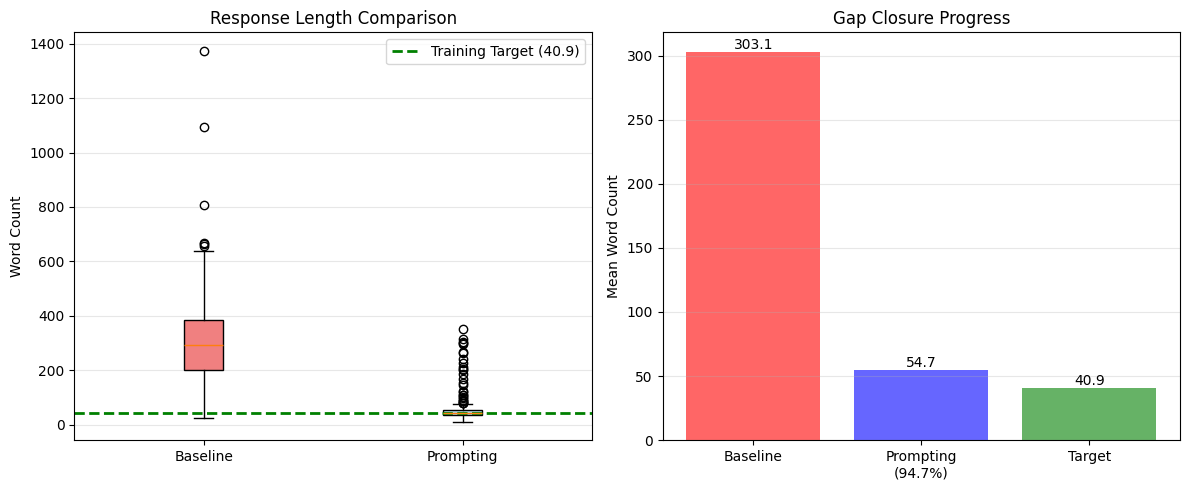

In [17]:
create_visualization(baseline_stats, training_stats, neo_stats, gap_results['gap_closure_pct'])